In [ ]:
!pip3 install openai
!pip3 install scikit-learn
!pip3 install tiktoken
!pip3 install scikit-llm

In [2]:
import csv
import torch
from transformers import BertTokenizer
import tensorflow as tf
# from torchtext.legacy import data
import pandas as pd
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import statistics
import math
import seaborn as sns

# Setting the style for the plots
sns.set(style="whitegrid")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls "/content/drive/MyDrive/Eshan_ML/CSCI_567"

application_metadata.csv  old_data_exploration	text_df_all.csv     Text_GPT_Classification.ipynb
Copy_of_BERT_3.ipynb	  patent-bert.pt	text_df_medium.csv  text_patentability_data.csv


In [5]:
root = "/content/drive/MyDrive/Eshan_ML/CSCI_567"

In [6]:
df = pd.read_csv(root + "/text_df_medium.csv")

In [7]:
df

,claims,status,abstracts
0,1-19. 20. The mutant endotoxin made accordin...,ISS,1-19. The mutant endotoxin is purified from th...
1,1-41. 42. An isolated peptide having an anti...,ISS,1-41. An isolated peptide having an antigenic ...
2,1-23. 24. An image processing device compris...,ABN,An image processing device comprising: a scann...
3,1-36. 37. The method of managing documents a...,ABN,The method of managing documents and messages ...
4,1. A terminal comprising: a period reader read...,ISS,"1. A terminal according to claim 1, further co..."
...,...,...,...
9932,"1. A method to manage network addresses, compr...",ABN,"A method to manage network addresses, comprisi..."
9933,"1. An air turbine starter, comprising: a housi...",ISS,"1. An air turbine starter, comprising: a housi..."
9934,1. A method of determining a set of infrared a...,ISS,A method of determining a set of infrared ampl...
9935,1. A distributed service system for assisting ...,ISS,A distributed service system for assisting ser...


In [8]:
# Create a mapping dictionary
class_mapping = {'ISS': 1, 'ABN': 0}
# Use the map function to replace values in the 'class' column
df['status'] = df['status'].map(class_mapping)

In [9]:
class_distribution = df['status'].value_counts()
percentage_distribution = (class_distribution / len(df)) * 100

print(percentage_distribution)
print(class_distribution)

1    68.139277
0    31.860723
Name: status, dtype: float64
1    6771
0    3166
Name: status, dtype: int64


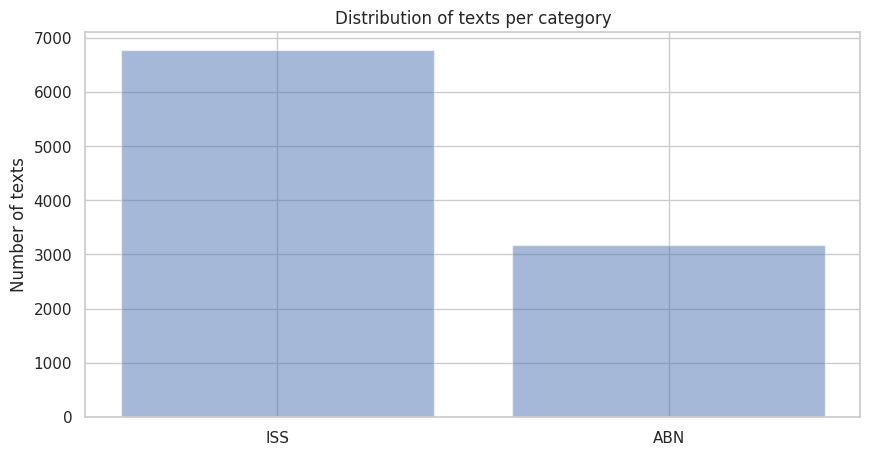

Counter({1: 6771, 0: 3166})


In [10]:
classes = df[['status']].values.reshape(-1)

counter_classes = Counter(classes)
class_names = ["ISS", "ABN"]#, "idk"]
class_values = counter_classes.values()

y_pos = np.arange(len(class_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, class_values, align='center', alpha=0.5)
plt.xticks(y_pos, class_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_classes)

In [11]:
#df['claims_split'] = df['claims'].apply(lambda x: x.split())

# Splitting the text column by spaces and finding the length of the split list
df['word_count'] = df['claims'].apply(lambda x: len(x.split()))
df['word_count'] = df['word_count'].astype(int)
# df.drop('claim_length', axis=1, inplace=True)

In [12]:
df.iloc[0]

claims        1-19.   20. The mutant endotoxin made accordin...
status                                                        1
abstracts     1-19. The mutant endotoxin is purified from th...
word_count                                                  255
Name: 0, dtype: object

In [13]:
# Calculating summary statistics for the word_count column per status class
summary_statistics_per_class = df.groupby('status')['word_count'].describe()
summary_statistics_per_class

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
0,3166.0,1055.355338,843.322451,15.0,564.25,859.5,1301.5,9888.0
1,6771.0,1258.943583,1178.004695,13.0,682.50,1022.0,1531.5,56481.0


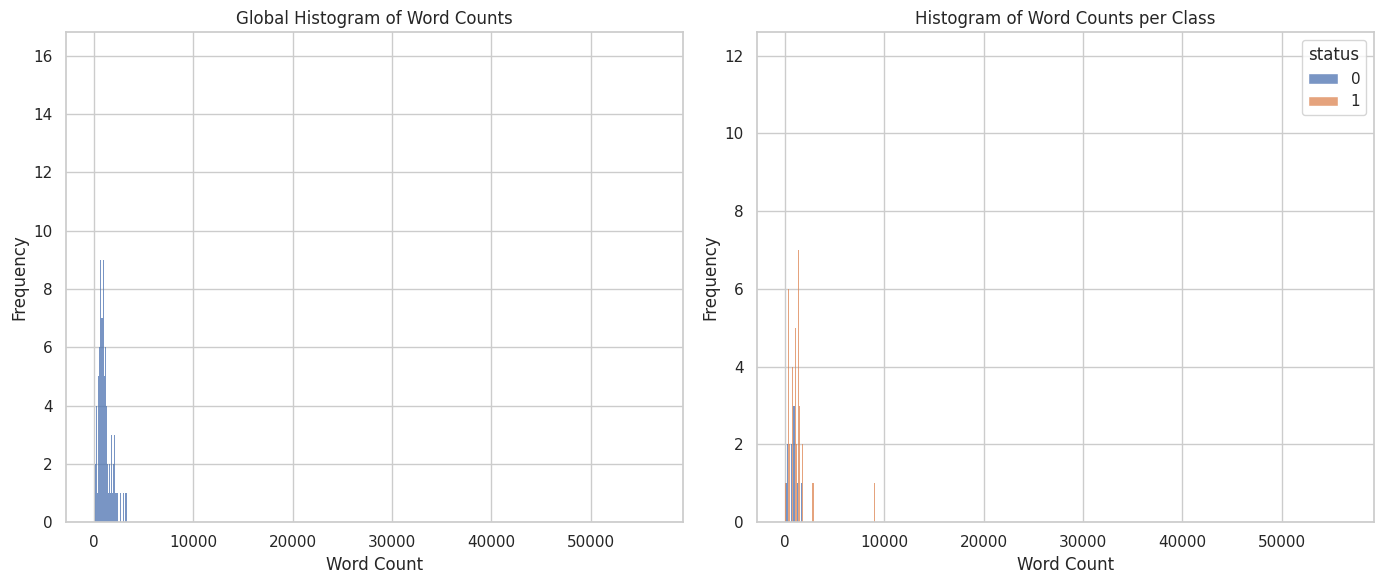

In [14]:
max_word_count = df['word_count'].max()

# Redefine the bins as a list of integers
bins = list(range(1, max_word_count + 2))

# Recreating the histograms with the adjusted bins and explicit float shrink value
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Global histogram of word counts
sns.histplot(df['word_count'], bins=bins, ax=axes[0], kde=False)
axes[0].set_title('Global Histogram of Word Counts')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

# Histogram of word counts per class
sns.histplot(data=df, x='word_count', hue='status', multiple="dodge",
             # shrink=0.8
              bins=bins, ax=axes[1])
axes[1].set_title('Histogram of Word Counts per Class')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

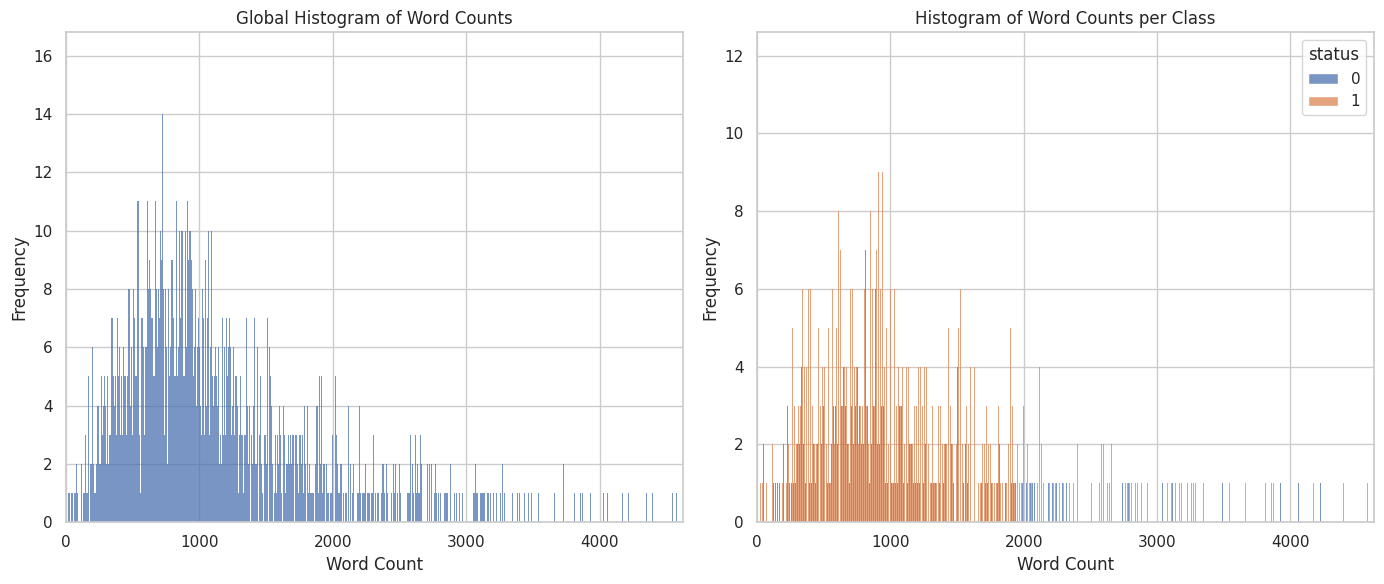

In [15]:
# Set the x-axis limit to the 99th percentile to reduce whitespace
xlim_max = df['word_count'].quantile(0.99)

# Recreating the histograms with adjusted x-axis limits
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Global histogram of word counts with adjusted x-axis
sns.histplot(df['word_count'], bins=bins, ax=axes[0], kde=False)
axes[0].set_title('Global Histogram of Word Counts')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, xlim_max)  # Adjusting the x-axis limit

# Histogram of word counts per class with adjusted x-axis
sns.histplot(data=df, x='word_count', hue='status', multiple="dodge",
             bins=bins, ax=axes[1])
axes[1].set_title('Histogram of Word Counts per Class')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, xlim_max)  # Adjusting the x-axis limit

plt.tight_layout()
plt.show()

In [16]:
# Iterate over rows
for index, row in df[:20].iterrows():
    print(row['claims'], row['status'])

1-19.   20. The mutant endotoxin made according to the method of claim 32, wherein the mutant endotoxin is purified from the mutant non-typeable Haemophilus influenzae by phenol-water extraction or proteinase digestion. 21.   22. The mutant non-typeable Haemophilus influenzae made according to the method of claim 34. 23-31.   32. A method of making a mutant endotoxin comprising: culturing a non-typeable Haemophilus influenzae strain having a mutation in htrB gene, wherein the htrB mutation produces a mutant non-typeable Haemophilus influenzae having a mutant endotoxin containing a decreased phosphoethanolamine content and an increased hexose content in the mutant endotoxin's inner core, and a pentaacylated or tetraacylated lipid A lacking one or two secondary acyl chains compared to the corresponding wild-type non-typeable Haemophilus influenzae hexaacylated endotoxin, and wherein the mutant endotoxin has substantially reduced toxicity as compared to the hexaacylated endotoxin of the w

In [17]:
import os
import re
from math import exp
import openai
import pandas as pd
from IPython.display import display, HTML
import json
from getpass import getpass

In [18]:
secret = getpass('Enter the secret value: ')

Enter the secret value: ··········


In [19]:
from skllm.config import SKLLMConfig
# Set your OpenAI API key
SKLLMConfig.set_openai_key(secret)

In [20]:
from skllm import ZeroShotGPTClassifier

In [21]:
clf_gpt_3 = ZeroShotGPTClassifier(openai_model="gpt-3.5-turbo-1106")
clf_gpt_4 = ZeroShotGPTClassifier(openai_model="gpt-4") # Currently points to gpt-4-0613

# Test

In [22]:
from skllm.datasets import get_classification_dataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
'''# Get the classification dataset from scikit-learn
X, y = get_classification_dataset()
# Fit the data
clf_gpt_3.fit(X, y)
clf_gpt_4.fit(X, y)

# Make predictions
preds_gpt_3 = clf_gpt_3.predict(X)
# Make predictions
preds_gpt_4 = clf_gpt_4.predict(X)


# Calculate Precision, Recall, and F1 Score
precision_3 = precision_score(y, preds_gpt_3)
recall_3 = recall_score(y, preds_gpt_3)
f1_3 = f1_score(y, preds_gpt_3)
accuracy_3 = accuracy_score(y, preds_gpt_3)

# Calculate Precision, Recall, and F1 Score
precision_4 = precision_score(y, preds_gpt_4)
recall_4 = recall_score(y, preds_gpt_4)
f1_4 = f1_score(y, preds_gpt_4)
accuracy_4 = accuracy_score(y, preds_gpt_4)

print(f"GPT 3 Precision: {precision_3}")
print(f"GPT 3 Recall: {recall_3}")
print(f"GPT 3 Score: {f1_3}")
print(f"GPT 3 Accuracy: {accuracy_3}")
print()
print(f"GPT 4 Precision: {precision_4}")
print(f"GPT 4 Recall: {recall_4}")
print(f"GPT 4 Score: {f1_4}")
print(f"GPT 4 Accuracy: {accuracy_4}")'''


'# Get the classification dataset from scikit-learn\nX, y = get_classification_dataset()\n# Fit the data\nclf_gpt_3.fit(X, y)\nclf_gpt_4.fit(X, y)\n\n# Make predictions\npreds_gpt_3 = clf_gpt_3.predict(X)\n# Make predictions\npreds_gpt_4 = clf_gpt_4.predict(X)\n\n\n# Calculate Precision, Recall, and F1 Score\nprecision_3 = precision_score(y, preds_gpt_3)\nrecall_3 = recall_score(y, preds_gpt_3)\nf1_3 = f1_score(y, preds_gpt_3)\naccuracy_3 = accuracy_score(y, preds_gpt_3)\n\n# Calculate Precision, Recall, and F1 Score\nprecision_4 = precision_score(y, preds_gpt_4)\nrecall_4 = recall_score(y, preds_gpt_4)\nf1_4 = f1_score(y, preds_gpt_4)\naccuracy_4 = accuracy_score(y, preds_gpt_4)\n\nprint(f"GPT 3 Precision: {precision_3}")\nprint(f"GPT 3 Recall: {recall_3}")\nprint(f"GPT 3 Score: {f1_3}")\nprint(f"GPT 3 Accuracy: {accuracy_3}")\nprint()\nprint(f"GPT 4 Precision: {precision_4}")\nprint(f"GPT 4 Recall: {recall_4}")\nprint(f"GPT 4 Score: {f1_4}")\nprint(f"GPT 4 Accuracy: {accuracy_4}")'

In [23]:
X = df["claims"].to_numpy()

In [24]:
y = df["status"].to_numpy()

In [25]:
X[0]

"1-19.   20. The mutant endotoxin made according to the method of claim 32, wherein the mutant endotoxin is purified from the mutant non-typeable Haemophilus influenzae by phenol-water extraction or proteinase digestion. 21.   22. The mutant non-typeable Haemophilus influenzae made according to the method of claim 34. 23-31.   32. A method of making a mutant endotoxin comprising: culturing a non-typeable Haemophilus influenzae strain having a mutation in htrB gene, wherein the htrB mutation produces a mutant non-typeable Haemophilus influenzae having a mutant endotoxin containing a decreased phosphoethanolamine content and an increased hexose content in the mutant endotoxin's inner core, and a pentaacylated or tetraacylated lipid A lacking one or two secondary acyl chains compared to the corresponding wild-type non-typeable Haemophilus influenzae hexaacylated endotoxin, and wherein the mutant endotoxin has substantially reduced toxicity as compared to the hexaacylated endotoxin of the 

### Note you can apply chunking later, if you want to

In [26]:
import tiktoken

def trim_input_gpt(X, max_len = 4096, chat_model="gpt-3.5-turbo"):

  # Initialize the tokenizer
  tokenizer = tiktoken.encoding_for_model(chat_model)
  X_trim = []
  for x in X:
    # Encode the text_data into token integers
    token_integers = tokenizer.encode(x)
    if len(token_integers) > max_len:
      X_trim.append(tokenizer.decode(token_integers[:max_len - 200]))
    else:
      X_trim.append(tokenizer.decode(token_integers))
  return X_trim

In [27]:
X_gpt_3 = trim_input_gpt(X, max_len=16385, chat_model="gpt-3.5-turbo-1106")
#X_gpt_4 = trim_input_gpt(X, max_len=8192, chat_model="gpt-4")

In [31]:
clf_gpt_3.fit(X_gpt_3, y)
# clf_gpt_4.fit(X_gpt_4, y)

# Make predictions
# train_preds_gpt_4 = clf_gpt_4.predict(X)

ZeroShotGPTClassifier(openai_model='gpt-3.5-turbo-1106')

In [ ]:
tmp_preds_gpt_3 = clf_gpt_3.predict(X_gpt_3[:100])

In [ ]:
precision_3 = precision_score(y[:100], tmp_preds_gpt_3)#, average='weighted')
recall_3 = recall_score(y[:100], tmp_preds_gpt_3)#, average='weighted')
f1_3 = f1_score(y[:100], tmp_preds_gpt_3)#, average='weighted')
accuracy_3 = accuracy_score(y[:100], tmp_preds_gpt_3)

print(f"Train GPT 3 Precision: {precision_3}")
print(f"Train GPT 3 Recall: {recall_3}")
print(f"Train GPT 3 Score: {f1_3}")
print(f"Train GPT 3 Accuracy: {accuracy_3}")

In [ ]:
# Make predictions
preds_gpt_3 = clf_gpt_3.predict(X_gpt_3[:7000])

In [ ]:
# 92%|█████████▏| 6416/7000 --> Rate Limit Error
preds_gpt_3

In [33]:
precision_3 = precision_score(y[:7000], preds_gpt_3)
recall_3 = recall_score(y[:7000], preds_gpt_3)
f1_3 = f1_score(y[:7000], preds_gpt_3)
accuracy_3 = accuracy_score(y[:7000], preds_gpt_3)

print(f"Train GPT 3 Precision: {precision_3}")
print(f"Train GPT 3 Recall: {recall_3}")
print(f"Train GPT 3 Score: {f1_3}")
print(f"Train GPT 3 Accuracy: {accuracy_3}")

Train GPT 3 Precision: 0.6820286195286195
Train GPT 3 Recall: 0.6795973998741874
Train GPT 3 Score: 0.6808108391975632
Train GPT 3 Accuracy: 0.5658571428571428
